<a href="https://colab.research.google.com/github/kpaulfran/sapceship_titanic/blob/main/sapceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
import numpy as np
set_config(display='diagram')

In [2]:
train = pd.read_csv('https://raw.githubusercontent.com/kpaulfran/sapceship_titanic/main/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/kpaulfran/sapceship_titanic/main/test.csv')

In [3]:
train.shape

(8693, 14)

1) Fuente de datos

Kaggle: https://www.kaggle.com/competitions/spaceship-titanic/data?select=train.csv

2) Breve descripción de datos

set of personal records recovered from the ship's damaged computer system.

3) ¿Cuál es el objetivo?

Predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. 

4) ¿Este es un problema de clasificación o regresión?

classifier

5) ¿Cuántas características hay?

14

6) ¿Cuántas filas de datos hay?

8693

7) ¿Qué retos, si es que hay alguno, prevén en la limpieza, exploración o modelización con este conjunto de datos?

Habra que realizar imputaciones en ciertas variables ya que superan el 1% de datos missing

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


In [6]:
#Exploración de datos por cada columna

train['PassengerId'].unique() # Sera separado al final #Grupo/# de persona en el grupo para evaluar si influye al graficarlo

array(['0001_01', '0002_01', '0003_01', ..., '9279_01', '9280_01',
       '9280_02'], dtype=object)

In [7]:
train['HomePlanet'].value_counts() #8492 datos / 201 datos na

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

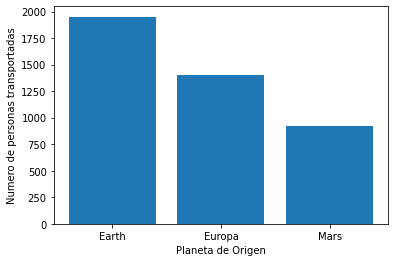

In [8]:
#Grafico de relacion entre HomePlanet y Transporte

#Analisis
true_filter = train['Transported'] == True 
train_grouped = train.loc[true_filter, :]
train_grouped = train_grouped.groupby(by=['HomePlanet']).count()
train_grouped.reset_index(inplace=True, drop=False)
train_grouped

plt.bar(train_grouped['HomePlanet'], train_grouped['Transported'])
plt.xlabel('Planeta de Origen')
plt.ylabel('Numero de personas transportadas')
plt.show

In [9]:
round(1-(train['HomePlanet'].value_counts().sum()/8693),2) #Los datos faltantes son menor al 1% por lo que estas filas seran eliminadas para este caso

0.02

In [10]:
train.dropna(subset=['HomePlanet'], inplace=True)
train.shape

(8492, 14)

In [11]:
train['CryoSleep'].value_counts().sum()/8492 #Luego se va a realizar la imputacion de estos datos utilizando el metodo 'most_frequent', se elige imputar por que ya hemos eliminado parte de nuestros datos

0.9746820536975978

<function matplotlib.pyplot.show(*args, **kw)>

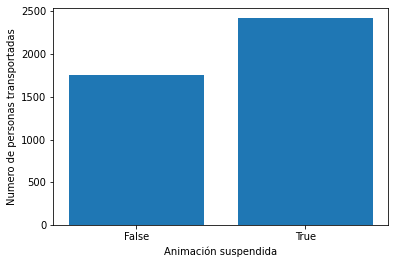

In [12]:
#Analisis
true_filter = train['Transported'] == True 
train_grouped = train.loc[true_filter, :]
train_grouped = train_grouped.groupby(by=['CryoSleep']).count()
train_grouped.reset_index(inplace=True, drop=False)
train_grouped

plt.bar(train_grouped['CryoSleep'].replace({True : 'True', False: 'False'}), train_grouped['Transported'])
plt.xlabel('Animación suspendida')
plt.ylabel('Numero de personas transportadas')
plt.show

In [13]:
train['Cabin'].unique() #Será separada al final, para luego graficarlo

array(['B/0/P', 'F/0/S', 'A/0/S', ..., 'G/1499/S', 'G/1500/S', 'E/608/S'],
      dtype=object)

In [14]:
train['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

<function matplotlib.pyplot.show(*args, **kw)>

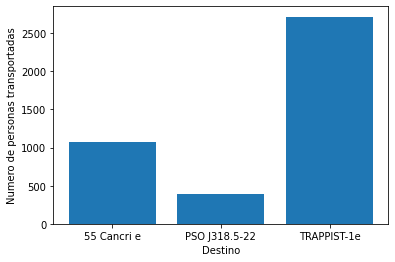

In [15]:
#Analisis
true_filter = train['Transported'] == True 
train_grouped = train.loc[true_filter, :]
train_grouped = train_grouped.groupby(by=['Destination']).count()
train_grouped.reset_index(inplace=True, drop=False)
train_grouped

plt.bar(train_grouped['Destination'], train_grouped['Transported'])
plt.xlabel('Destino')
plt.ylabel('Numero de personas transportadas')
plt.show

In [16]:
train['Destination'].value_counts()

TRAPPIST-1e      5765
55 Cancri e      1769
PSO J318.5-22     780
Name: Destination, dtype: int64

In [17]:
train['Destination'].isna().sum()/train['Destination'].value_counts().sum() #Luego se va a realizar la imputacion de estos datos utilizando el metodo 'most_frequent', se elige imputar por que ya hemos eliminado parte de nuestros datos

0.02140967043541015

In [18]:
train['Age'].describe()

count    8315.000000
mean       28.828743
std        14.490024
min         0.000000
25%        19.000000
50%        27.000000
75%        38.000000
max        79.000000
Name: Age, dtype: float64

In [19]:
train['Age'].isna().sum()  #Luego se va a realizar la imputacion de estos datos utilizando el metodo 'mean'

177

In [20]:
train['VIP'].isna().sum()  #Luego se va a realizar la imputacion de estos datos utilizando el metodo 'most_frequent', se elige imputar por que ya hemos eliminado parte de nuestros datos

200

In [21]:
train['VIP'].value_counts()

False    8098
True      194
Name: VIP, dtype: int64

<function matplotlib.pyplot.show(*args, **kw)>

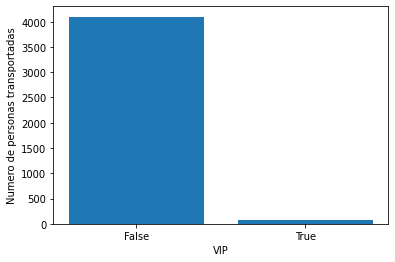

In [22]:
#Analisis
true_filter = train['Transported'] == True 
train_grouped = train.loc[true_filter, :]
train_grouped = train_grouped.groupby(by=['VIP']).count()
train_grouped.reset_index(inplace=True, drop=False)
train_grouped

plt.bar(train_grouped['VIP'].replace({True: 'True', False: 'False'}), train_grouped['Transported'])
plt.xlabel('VIP')
plt.ylabel('Numero de personas transportadas')
plt.show

In [23]:
#Columnas de gastos en el spaceship seran sumadas 'total_billed'

In [24]:
#Eliminaremos Name para este análisis

train.drop(columns=['Name'], inplace = True)

In [25]:
train['Transported'].isna().sum() #Datos completos en columna objetivo

0

In [26]:
train['Transported'].value_counts() #Datos balanceados para una correcta clasificacion

True     4275
False    4217
Name: Transported, dtype: int64

In [27]:
#Segunda fase de la exploración y limpieza:

#Separar datos de las columnas 'PassengerID' y 'Cabin'

train['GroupId'] = train['PassengerId'].str.slice(stop = 4)
train['GroupId']

0       0001
1       0002
2       0003
3       0003
4       0004
        ... 
8688    9276
8689    9278
8690    9279
8691    9280
8692    9280
Name: GroupId, Length: 8492, dtype: object

In [28]:
train['PersonNumber'] = train['PassengerId'].str.slice(start = 5)
train.drop(columns=['PassengerId'],inplace=True)
train['PersonNumber']

0       01
1       01
2       01
3       02
4       01
        ..
8688    01
8689    01
8690    01
8691    01
8692    02
Name: PersonNumber, Length: 8492, dtype: object

In [29]:
#Cabin = [deck,num,side]

train[['deck','num','side']] = train['Cabin'].str.split('/', expand = True)
train.drop(columns=['Cabin'],inplace=True)

train['side']

0       P
1       S
2       S
3       S
4       S
       ..
8688    P
8689    S
8690    S
8691    S
8692    S
Name: side, Length: 8492, dtype: object

In [30]:
#Crearemos la columna total_billed y eliminaremos las columnas utilizadas.

#sums=df.sum(axis=1)

train['total_billed'] = train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
train.drop(columns=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8492 entries, 0 to 8692
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8277 non-null   object 
 2   Destination   8314 non-null   object 
 3   Age           8315 non-null   float64
 4   VIP           8292 non-null   object 
 5   Transported   8492 non-null   bool   
 6   GroupId       8492 non-null   object 
 7   PersonNumber  8492 non-null   object 
 8   deck          8299 non-null   object 
 9   num           8299 non-null   object 
 10  side          8299 non-null   object 
 11  total_billed  8492 non-null   float64
dtypes: bool(1), float64(2), object(9)
memory usage: 804.4+ KB


In [31]:
train.shape

(8492, 12)

In [32]:
#Analizaremos las nuevas columnas

train['GroupId'].value_counts() #No se observan tendencias

9081    8
8796    8
8728    8
5885    8
4256    8
       ..
3465    1
3462    1
3461    1
3459    1
4622    1
Name: GroupId, Length: 6107, dtype: int64

In [33]:
#Analisis
true_filter = train['Transported'] == True 
train_grouped = train.loc[true_filter, :]
train_grouped = train.groupby(by=['GroupId']).count()
train_grouped[['Transported','VIP']].sort_values(by = ['Transported'],ascending=False)[:10] #Se observa una fuerte tendencia a que los pasajeron VIP sean los que sean transportados, por lo que utilizaremos esta información sobre el GroupId y el numero de persona en el grupo

,Transported,VIP
GroupId,,
9081,8,7
8796,8,8
8728,8,8
5885,8,7
4256,8,8
8988,8,8
4005,8,8
5133,8,8
0984,8,8


In [34]:
train.drop(columns=['GroupId', 'PersonNumber'], inplace = True)

In [35]:
#Analisis de columnas deck, num, side

true_filter = train['Transported'] == True 
train_grouped = train.loc[true_filter, :]
train_grouped = train.groupby(by=['deck']).count()
train_grouped[['Transported','VIP']].sort_values(by = ['Transported'],ascending=False)[:10] #Se va a mantener por que se observa una correlacion entre el deck y los que son transportados

,Transported,VIP
deck,,
F,2724,2656
G,2498,2433
E,853,838
B,766,754
C,734,715
D,468,459
A,252,246
T,4,4


In [36]:
true_filter = train['Transported'] == True 
train_grouped = train.loc[true_filter, :]
train_grouped = train.groupby(by=['num']).count()
train_grouped[['Transported','VIP']].sort_values(by = ['Transported'],ascending=False)[:10] #la variacion entre transportadl y VIP por num es minima, no lo utilizaremos

,Transported,VIP
num,,
82,28,27
97,21,20
176,21,21
86,20,19
19,20,19
56,20,20
230,20,20
65,19,19
123,19,18


In [37]:
train.drop(columns=['num'], inplace=True)

In [38]:
true_filter = train['Transported'] == True 
train_grouped = train.loc[true_filter, :]
train_grouped = train.groupby(by=['side']).count()
train_grouped[['Transported','VIP']].sort_values(by = ['Transported'],ascending=False)[:10] #no es considerable, se eliminara

,Transported,VIP
side,,
S,4186,4085
P,4113,4020


In [39]:
train.drop(columns=['side'], inplace=True)

In [40]:
train.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,deck,total_billed
0,Europa,False,TRAPPIST-1e,39.0,False,False,B,0.0
1,Earth,False,TRAPPIST-1e,24.0,False,True,F,736.0
2,Europa,False,TRAPPIST-1e,58.0,True,False,A,10383.0
3,Europa,False,TRAPPIST-1e,33.0,False,False,A,5176.0
4,Earth,False,TRAPPIST-1e,16.0,False,True,F,1091.0


In [41]:
train.isna().sum()

HomePlanet        0
CryoSleep       215
Destination     178
Age             177
VIP             200
Transported       0
deck            193
total_billed      0
dtype: int64

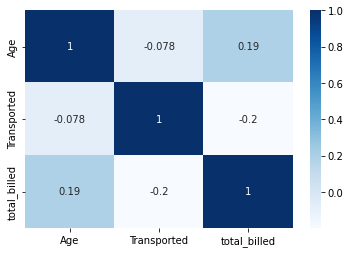

In [42]:
corr = train.corr()
sns.heatmap(corr,annot = True, cmap = 'Blues')

Para imputar los valores se van a utilizar las metodología:

- mean para valores numericos
- most frequent para valores categoricos

In [43]:
# Dividimo nuestro dataset
X = train.drop('Transported', axis=1)
y = train['Transported']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [44]:
numeric_pipe = make_pipeline(mean_imputer, scaler)
categorical_pipe = make_pipeline(freq_imputer, ohe)

In [45]:
# Tuples para Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff1069f8610>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff106705b20>)])

In [46]:
preprocessor.fit(X_train)


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff1069f8610>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7ff106705b20>)])

In [47]:
# transform train and test
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [48]:
# Comprueben los valores faltantes y que los datos se escalen y tengan una codificación one-hot
print(np.isnan(X_train).sum().sum(), 'missing values in training data')
print(np.isnan(X_test).sum().sum(), 'missing values in testing data')
print('All data in X_train_processed are', X_train.dtype)
print('All data in X_test_processed are', X_test.dtype)
print('shape of data is', X_train.shape)

0 missing values in training data
0 missing values in testing data
All data in X_train_processed are float64
All data in X_test_processed are float64
shape of data is (6369, 20)


Una vez que tenemos listo nuestros datos para procesar.

Vamos a decidir el tipo de algoritmo que vamos a utilizar para la predicción de nuestros datos.

Probaremos los modelos de clasificación:

- Arbol de decisión
- KNN
- Regresión logística

In [49]:
# Arbol de decision - Bosques Aleatorios

from sklearn.ensemble import RandomForestClassifier

In [50]:
max_depths = range(2,20,1)
rf_train_score = []
rf_test_score = []

for depth in max_depths:
  rf = RandomForestClassifier(max_depth = depth, random_state = 42)
  rf.fit(X_train, y_train)
  rf.predict(X_test)
  rf_train_score.append(rf.score(X_train, y_train))
  rf_test_score.append(rf.score(X_test, y_test))


Text(0, 0.5, 'rf_test')

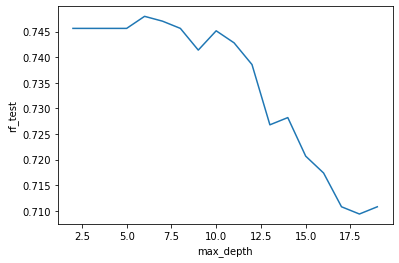

In [51]:
plt.plot(max_depths, rf_test_score)
plt.xlabel('max_depth')
plt.ylabel('rf_test')

In [52]:
rf = RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train, y_train)
rf.predict(X_test)
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)

print('Train score:',rf_train_score)
print('Test score:', rf_test_score)

Train score: 0.7425027476840949
Test score: 0.7479981158737635


In [53]:
# KNN Classifier

from sklearn.neighbors import KNeighborsClassifier

In [54]:
n_neighbors = range(2,20,1)
knn_train_score = []
knn_test_score = []

for n in n_neighbors:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(X_train, y_train)
  knn.predict(X_test)
  knn_train_score.append(knn.score(X_train, y_train))
  knn_test_score.append(knn.score(X_test, y_test))

Text(0, 0.5, 'knn_test')

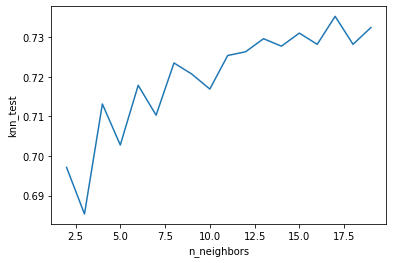

In [55]:
plt.plot(n_neighbors, knn_test_score)
plt.xlabel('n_neighbors')
plt.ylabel('knn_test')

In [56]:
knn = KNeighborsClassifier(n_neighbors=17)

knn.fit(X_train, y_train)

print(knn.score(X_train, y_train))
print(knn.score(X_test, y_test))

0.7544355471816612
0.7352802637776731


In [57]:
#Regresion Logistica

from sklearn.linear_model import LogisticRegression

In [58]:
logreg = LogisticRegression(C = 0.01)
logreg.fit(X_train, y_train)
print(logreg.score(X_train,y_train))
print(logreg.score(X_test,y_test))

0.725702622075679
0.7376354215732454


{0.0001: 0.49034385303815353,
 0.001: 0.7286858219500707,
 0.01: 0.730098916627414,
 0.1: 0.7362223268959021,
 1: 0.7352802637776731,
 10: 0.7348092322185587,
 100: 0.7348092322185587,
 1000: 0.7348092322185587}

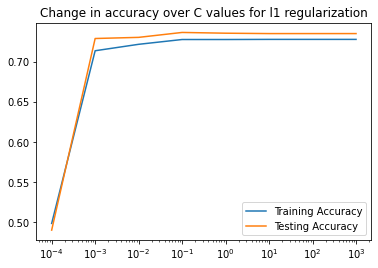

In [59]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
 
  # instantiate a model with each value of c and fit it on the data
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  log_reg_pipe = make_pipeline(scaler, log_reg)
  log_reg_pipe.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))
 
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
 
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

{0.0001: 0.7268016957136129,
 0.001: 0.730098916627414,
 0.01: 0.7343382006594442,
 0.1: 0.7362223268959021,
 1: 0.7348092322185587,
 10: 0.7348092322185587,
 100: 0.7348092322185587,
 1000: 0.7348092322185587}

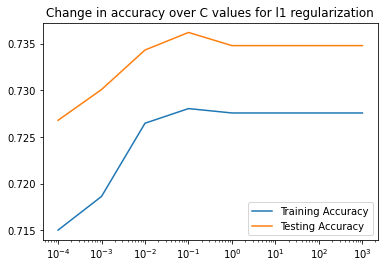

In [60]:
# create a list of c values and empty lists for scores
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
#iterative over the c values
for c in c_values:
 
  # instantiate a model with each value of c and fit it on the data
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  log_reg_pipe = make_pipeline(scaler, log_reg)
  log_reg_pipe.fit(X_train, y_train)
 
  # add the training and testing scores to our scores lists
  train_scores.append(log_reg_pipe.score(X_train, y_train))
  test_scores.append(log_reg_pipe.score(X_test, y_test))
 
#plot the change in accuracy as we change the value of C
fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
 
#set the x axis to a logarithmic scale to show the values of C in even intervals
ax.set_xscale('log')
# print a dictionary of values of C and accuracy scores
{c:score for c, score in zip(c_values, test_scores)}

In [61]:
logreg = LogisticRegression(C=0.1, max_iter=1000, solver='liblinear', penalty='l1')
logreg.fit(X_train, y_train)
print(logreg.score(X_train,y_train))
print(logreg.score(X_test,y_test))

0.7247605589574502
0.7371643900141309


In [62]:
print('Score de modelos de clasificación utilizados:\n')
print('Random Forest test score:', rf_test_score, '\n')
print('KNN test score:', knn.score(X_test, y_test), '\n')
print('Regresion logistica test score: ', logreg.score(X_test,y_test))

Score de modelos de clasificación utilizados:

Random Forest test score: 0.7479981158737635 

KNN test score: 0.7352802637776731 

Regresion logistica test score:  0.7371643900141309


Por lo que podemos inferir que nuestro mejor modelo al momento es el Random Forest, sin embargo evaluaremos un poco mas nuestros datos.

Matriz de correlaciones:

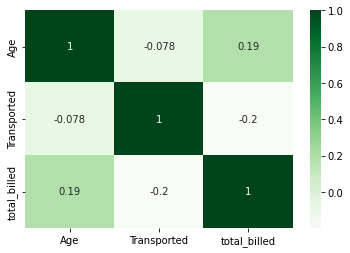

In [63]:
corr = train.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True)

In [64]:
#No influye la edad, sin embargo se observa que los que fueron transportados gastaron mucho menos que los que no lo fueron

train.groupby(by='Transported').mean()

,Age,total_billed
Transported,,
False,29.971172,2013.140147
True,27.702412,892.130994


In [65]:
#Dado que mis datos, son en su mayoría categoricos y nuestro mejor modelo puntuado fue el RandomForest,
#Nos vamos a centrar en este, y vamos potenciarlo para mejorar su predicción.

In [66]:
#Visualizamos los parametros utilizados para el Random Forest

rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 6,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Text(0, 0.5, 'rf_test')

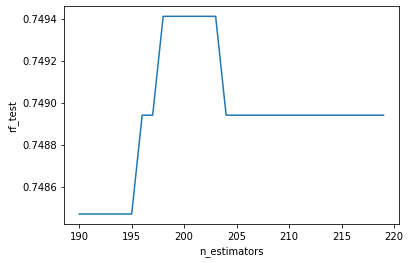

In [67]:
#Vamos a ajustar en n_estimators

rf_train_score = []
rf_test_score = []
n_estimators = range(190,220,1)

for n in n_estimators:
  rf = RandomForestClassifier(max_depth = 6, random_state = 42, n_estimators = n)
  rf.fit(X_train, y_train)
  rf.predict(X_test)
  rf_test_score.append(rf.score(X_test, y_test))

plt.plot(n_estimators, rf_test_score)
plt.xlabel('n_estimators')
plt.ylabel('rf_test')

In [68]:
rf = RandomForestClassifier(max_depth = 6, random_state = 42, n_estimators = 198)
rf.fit(X_train, y_train)
rf.predict(X_test)
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)

print('Train score:',rf_train_score)
print('Test score:', rf_test_score)

Train score: 0.7425027476840949
Test score: 0.7494112105511069


In [69]:
test.drop(columns=['Name','PassengerId'], inplace = True)
test.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0


In [70]:
test['total_billed'] = test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)
test.drop(columns=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'],inplace=True)
test.head(5)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,total_billed
0,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0
1,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,2832.0
2,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0
3,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,7418.0
4,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,645.0


In [71]:

test[['deck','num','side']] = test['Cabin'].str.split('/', expand = True)
test.drop(columns=['Cabin', 'num', 'side'],inplace=True)

In [72]:
test.head(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,total_billed,deck
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,G
1,Earth,False,TRAPPIST-1e,19.0,False,2832.0,F
2,Europa,True,55 Cancri e,31.0,False,0.0,C
3,Europa,False,TRAPPIST-1e,38.0,False,7418.0,C
4,Earth,False,TRAPPIST-1e,20.0,False,645.0,F


In [73]:
test = preprocessor.transform(test)

In [74]:
transported = rf.predict(test)
transported = pd.Series(transported)

In [75]:
test_ = pd.read_csv('https://raw.githubusercontent.com/kpaulfran/sapceship_titanic/main/test.csv')

In [76]:
test_ = pd.concat([test_['PassengerId'], transported], axis =1)
test_ = test_.rename(columns={0: 'Transported'})

In [77]:
test_.to_csv('Test_3', index = False)

<function matplotlib.pyplot.show(*args, **kw)>

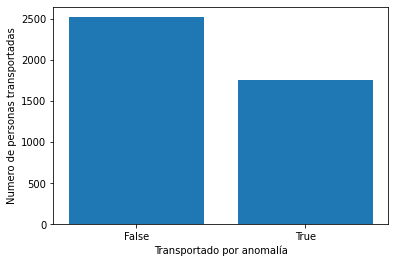

In [78]:
#Analisis
test_grouped = test_.groupby(by=['Transported']).count()
test_grouped.reset_index(inplace=True, drop=False)

plt.bar(test_grouped['Transported'].replace({False:'False', True:'True'}), test_grouped['PassengerId'])
plt.xlabel('Transportado por anomalía')
plt.ylabel('Numero de personas transportadas')
plt.show

In [79]:
test_grouped

,Transported,PassengerId
0,False,2521
1,True,1756


In [81]:
porcentaje = 100* 1756/(2521+1756)
print(f'El porcentaje de personas transportadas es:{round(porcentaje,2)}%')

El porcentaje de personas transportadas es:41.06%
